In [41]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Process, Queue

In [42]:
class RandomAction:
    def __init__(self, n_states=19, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = np.random.choice([-1, 1])
        self.state += action
        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [43]:
class TrueOnlineTDLambda:
    def __init__(self, alpha, lamda, epi=10, do=False):
        self.V = np.zeros(19)
        self.alpha = alpha
        self.lamda = lamda
        self.gamma = 1
        self.epi = epi
        
        if do:
            self.do()
        
    def do(self):
        env = RandomAction()

        for episode in range(self.epi):
            state = env.reset()
            done = False

            z = np.zeros(19)
            V_old = 0

            while not done:
                next_state, reward, done = env.step()

                x = np.zeros(19)
                x_next = np.zeros(19)
                
                x[state] = 1
                V = self.V[state]

                if not done:
                    x_next[next_state] = 1
                    V_next = self.V[next_state]

                else:
                    V_next = 0

                delta = reward + self.gamma * V_next - V
                z = self.lamda * self.gamma * z + (1 - self.alpha * self.gamma * self.lamda * z @ x) * x
                self.V += self.alpha * (delta + V - V_old) * z - self.alpha * (V - V_old) * x
                V_old = V_next
                x = x_next

                state = next_state

In [44]:
def RMS_RA(V):
    V = np.array(V)
    return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))

In [45]:
q = Queue()

alphas = np.linspace(0, 1, 51)
lamda_s = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]

def work(alpha, rd_seed):
    np.random.seed(rd_seed)

    table_ = []
    for lamda in lamda_s:
        gs = [TrueOnlineTDLambda(alpha, lamda, do=True) for _ in range(200)]
        TD_RMS = [RMS_RA(g.V) for g in gs]
        table_.append(np.mean(TD_RMS, axis=0))

    q.put((alpha, table_))

In [46]:
th_s = []

for alpha in alphas:
    th_s.append(Process(target=work, args=(alpha, np.random.randint(0, 1000000))))

for th in th_s:
    th.start()

for th in th_s:
    th.join()

In [47]:
table = []
for i in range(len(alphas)):
    table.append(q.get())
    table.sort(key=lambda x: x[0])
    n_table = np.array([x[1] for x in table])

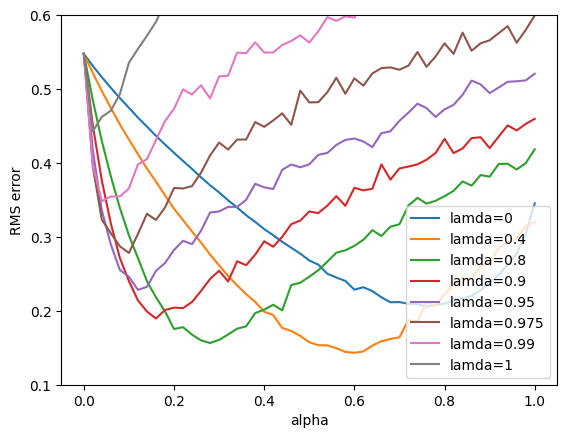

In [52]:
for i in range(len(lamda_s)):
    plt.plot(alphas, n_table[:, i], label=f'lamda={lamda_s[i]}')

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.legend()
plt.ylim([0.1, 0.6])
plt.show()